In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
import statsmodels.robust.robust_linear_model as rlm
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.tools.tools import pinv_extended
from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import ElasticNet, ElasticNetCV
from scipy.stats import boxcox
from scipy.linalg import toeplitz
from fractions import Fraction

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Laptop_Data_Reduced = pd.read_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Laptop_Data_Reduced.csv')
Laptop_Data_Reduced.head()

,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Other,Company_Toshiba,OpSys_Linux,OpSys_No OS,OpSys_Windows 7,...,MemoryGB1_Other,MemoryType1_HDD,ScreenResolution_1600x900,ScreenResolution_2560x1440,ScreenResolution_3840x2160,ScreenDisplayType_None,ScreenDisplayType_Quad HD+,ScreenIPSPanel_Yes,ScreenTouchscreen_Yes,Price
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,30636.000
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,21312.000
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,79653.600
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,41025.600
4,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,20986.992


In [ ]:
# Split and normalize the data, transfrom y variable

X = Laptop_Data_Reduced.drop('Price', axis=1)
y = Laptop_Data_Reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)

In [ ]:
y_train_temp, optimal_lambda = boxcox(y_train)
print(optimal_lambda)

0.09457515233235643


In [ ]:
def display_value (transformation_value):
  if transformation_value == 0:
    return 'ln(x)', 'ln(ln(x))'
  elif transformation_value in transformation_values_factions_and_whole:
    return 'x^' + str(Fraction(transformation_value).limit_denominator(10)), 'ln^' + str(Fraction(transformation_value).limit_denominator(10)) + '(x)'
  elif transformation_value == optimal_lambda:
    return 'x^' + str(round(transformation_value, 2)), 'ln^' + str(round(transformation_value, 2)) + '(x)'
  else:
    return 'x^' + str(transformation_value), 'ln^' + str(transformation_value) + '(x)'

transformation_values_factions_and_whole = [-2, -3/2, -1, -1/2, -1/3, -1/4, -1/5, 0, 1/5, 1/4, 1/3, 1/2, 1, 3/2, 2]
transformation_values_decimals = [optimal_lambda]
transformation_values = sorted(transformation_values_factions_and_whole + transformation_values_decimals)

transformation_values_display_normal = [display_value(i)[0] for i in transformation_values]
transformation_values_display_compound = [display_value(i)[1] for i in transformation_values]
transformation_values_display = transformation_values_display_normal + transformation_values_display_compound
transformation_values_display.remove('ln^1(x)')

In [ ]:
# Define Functions
def transform (array, i):
  if str(round(optimal_lambda, 2)) in i:
    i = i.replace(str(round(optimal_lambda, 2)), str(optimal_lambda))

  if i == 'ln(x)':
    return np.log(array)
  elif i == 'ln(ln(x))':
    return np.log(np.log(array))
  elif 'x^' in i:
    value = eval(re.search("-?(\d+\/\d+|\d*\.?\d+)", i)[0])
    return np.power(array, value)
  else:
    value = eval(re.search("-?(\d+\/\d+|\d*\.?\d+)", i)[0])
    return np.power(np.log(array), value)

def obtain_residuals (model_or_reg_model):
  predictions_train = model_or_reg_model.predict(X_train_constant)
  residuals_train = y_train_trans - predictions_train
  predictions_test = model_or_reg_model.predict(X_test_constant)
  residuals_test = y_test_trans - predictions_test
  return residuals_train, residuals_test

def pseudo_adj_rsquared (model_or_summary_base):
  pseudo_r2 = model_or_summary_base.pseudo_rsquared()
  n, p = model_or_summary_base.nobs, len(model_or_summary_base.params) - 1
  pseudo_adj_r2 = 1 - ((n - 1) / (n - p - 1)) * (1 - pseudo_r2)
  return pseudo_adj_r2

def new_row (model_or_summary_base, residuals_train, residuals_test, name):
  adj_r2 = model_or_summary_base.rsquared_adj if hasattr(model_or_summary_base, 'rsquared_adj') \
    else (pseudo_adj_rsquared(model_or_summary_base) if hasattr(model_or_summary_base, 'pseudo_rsquared') else '')
  dw = durbin_watson(residuals_train)
  jb = jarque_bera(residuals_train)[1]
  norm_train = diag.normal_ad(residuals_train)[1]
  norm_test = diag.normal_ad(residuals_test)[1]
  hetero_train = diag.het_white(residuals_train, X_train_constant)[1]
  new_row_data = [i, name, adj_r2, dw, jb, norm_train, norm_test, hetero_train]
  summary_table.loc[len(summary_table)] = new_row_data
  return summary_table

In [ ]:
#summary_table = pd.DataFrame(columns = ['Transformation', 'Model', 'Adj R2', 'Durbin Watson', 'Jarque Bera', 'Norm Train', 'Norm Test', 'Hetero Train'])
summary_table = pd.read_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Summary_Table_4.csv')

In [ ]:
# OLS
for i in transformation_values_display:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'OLS')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_ols = sm.OLS(y_train_trans, X_train_constant).fit()
    residuals_train_ols, residuals_test_ols = obtain_residuals(model_ols)
    summary_table = new_row(model_ols, residuals_train_ols, residuals_test_ols, 'OLS')

In [ ]:
# OLS Elastic

def function(array):
  result = 0.9 * (array - 1)**3 + 1
  inverse = abs((array - 1) / 0.9)**(1/3) * np.where((array) < 1, -1, 1) + 1
  return result, inverse

def elastic_net_search (alpha_values, l1_ratio_values):
  elastic_net_cv = ElasticNetCV(alphas = alpha_values, l1_ratio = l1_ratio_values, cv = cv)
  elastic_net_cv.fit(X_train, y_train_trans)
  return elastic_net_cv.alpha_, elastic_net_cv.l1_ratio_

#transformation_values_table = pd.DataFrame(columns = ['Transformation', 'Best Alpha', 'Best L1'])
transformation_values_table = pd.read_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Transformation_Values_Table_4.csv')

for i in transformation_values_display:
  if i not in [element for element in transformation_values_table['Transformation'].tolist()]:
    y_train_trans = transform(y_train, i)
    cv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

    alpha_values_1, l1_ratio_values_1 = [5e-3, 5e-2, 5e-1, 5], function(np.arange(0.05, 1, 0.1))[0]
    best_alpha_1, best_l1_ratio_1 = elastic_net_search(alpha_values_1, l1_ratio_values_1)

    alpha_values_2 = (np.arange(best_alpha_1 / 5, best_alpha_1 * 2.0000001, best_alpha_1 / 5))
    l1_ratio_values_2 = function(np.arange(function(best_l1_ratio_1)[1] - 0.05, function(best_l1_ratio_1)[1] + 0.06, 0.01))[0]
    best_alpha_2, best_l1_ratio_2 = elastic_net_search(alpha_values_2, l1_ratio_values_2)

    new_row_data_transformation = [i, best_alpha_2, best_l1_ratio_2]
    transformation_values_table.loc[len(transformation_values_table)] = new_row_data_transformation

In [ ]:
#transformation_values_table = transformation_values_table.drop([0], axis=0)
#transformation_values_table.loc[0, 'Lambda'] = ''

transformation_values_table.reset_index(drop=True, inplace=True)
display(transformation_values_table)

,Transformation,Best Alpha,Best L1
0,x^-2,10.000,0.100000
1,x^-3/2,10.000,0.100000
2,x^-1,10.000,0.100000
3,x^-1/2,10.000,0.100000
4,x^-1/3,0.001,0.100000
5,x^-1/4,0.001,0.100000
6,x^-1/5,0.001,0.100000
7,ln(x),0.001,0.100000
8,x^0.09,0.001,0.100000
9,x^1/5,0.001,0.100000


In [ ]:
transformation_values_table.to_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Transformation_Values_Table_4.csv', index=False)

In [ ]:
for i in transformation_values_display:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'OLS Elastic')).any():
    best_alpha = transformation_values_table.loc[transformation_values_table['Transformation'] == i, 'Best Alpha'].iloc[0]
    best_l1_ratio = transformation_values_table.loc[transformation_values_table['Transformation'] == i, 'Best L1'].iloc[0]
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_ols_elastic = sm.OLS(y_train_trans, X_train_constant)
    model_regularized_ols_elastic = model_ols_elastic.fit_regularized(method = 'elastic_net', alpha = best_alpha, L1_wt = best_l1_ratio)
    pinv_wexog,_ = pinv_extended(model_ols_elastic.wexog)
    model_regularized_ols_elastic_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    summary_base_ols_elastic = sm.regression.linear_model.OLSResults(model_ols_elastic, model_regularized_ols_elastic.params, model_regularized_ols_elastic_cov_params)

    residuals_train_ols_elastic, residuals_test_ols_elastic = obtain_residuals(model_regularized_ols_elastic)
    summary_table = new_row(summary_base_ols_elastic, residuals_train_ols_elastic, residuals_test_ols_elastic, 'OLS Elastic')

In [ ]:
# Perform weighted least squares
# some code was taken from GeeksforGeeks

# WLS1
for i in transformation_values_table['Transformation']:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'WLS1')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_ols = sm.OLS(y_train_trans, X_train_constant).fit()
    residuals_train_ols, residuals_test_ols = obtain_residuals(model_ols)
    weights_train1 = 1 / sm.OLS(abs(residuals_train_ols), model_ols.predict(X_train_constant)).fit().fittedvalues**2
    weights_test1 = 1 / sm.OLS(abs(residuals_test_ols), model_ols.predict(X_test_constant)).fit().fittedvalues**2

    model_wls1 = sm.WLS(y_train_trans, X_train_constant, weights = weights_train1).fit()
    residuals_train_wls1, residuals_test_wls1 = obtain_residuals(model_wls1)
    residuals_train_wls1_weighted, residuals_test_wls1_weighted = residuals_train_wls1 * np.sqrt(weights_train1), residuals_test_wls1 * np.sqrt(weights_test1)
    summary_table = new_row(model_wls1, residuals_train_wls1_weighted, residuals_test_wls1_weighted, 'WLS1')

In [ ]:
# Perform weighted least squares
# some code was taken from GeeksforGeeks

# WLS2
for i in transformation_values_table['Transformation']:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'WLS2')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_ols = sm.OLS(y_train_trans, X_train_constant).fit()
    residuals_train_ols, residuals_test_ols = obtain_residuals(model_ols)
    weights_train2 = 1 / sm.OLS(residuals_train_ols**2, model_ols.predict(X_train_constant)).fit().fittedvalues**2
    weights_test2 = 1 / sm.OLS(residuals_test_ols**2, model_ols.predict(X_test_constant)).fit().fittedvalues**2

    model_wls2 = sm.WLS(y_train_trans, X_train_constant, weights = weights_train2).fit()
    residuals_train_wls2, residuals_test_wls2 = obtain_residuals(model_wls2)
    residuals_train_wls2_weighted, residuals_test_wls2_weighted = residuals_train_wls2 * np.sqrt(weights_train2), residuals_test_wls2 * np.sqrt(weights_test2)
    summary_table = new_row(model_wls2, residuals_train_wls2_weighted, residuals_test_wls2_weighted, 'WLS2')

In [ ]:
# Robust Linear Models
for i in transformation_values_table['Transformation']:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'RLM')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_rlm = sm.RLM(y_train_trans, X_train_constant, M=sm.robust.norms.TukeyBiweight()).fit()
    residuals_train_rlm, residuals_test_rlm = obtain_residuals(model_rlm)
    summary_table = new_row(model_rlm, residuals_train_rlm, residuals_test_rlm, 'RLM')

In [ ]:
# GLS
# some code was taken from GeeksforGeeks

for i in transformation_values_table['Transformation']:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'GLS')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_ols = sm.OLS(y_train_trans, X_train_constant).fit()
    residuals_train, residuals_test = obtain_residuals(model_ols)

    for _ in range(5):
      resid_fit = sm.OLS(residuals_train[1:].reset_index(drop=True), sm.add_constant(residuals_train[:-1].reset_index(drop=True))).fit()
      rho = resid_fit.params.iloc[1]
      sigma = rho**toeplitz(np.arange(len(residuals_train)))
      model_gls = sm.GLS(y_train_trans, X_train_constant, sigma=sigma).fit()
      residuals_train, residuals_test = obtain_residuals(model_gls)

    summary_table = new_row(model_gls, residuals_train, residuals_test, 'GLS')

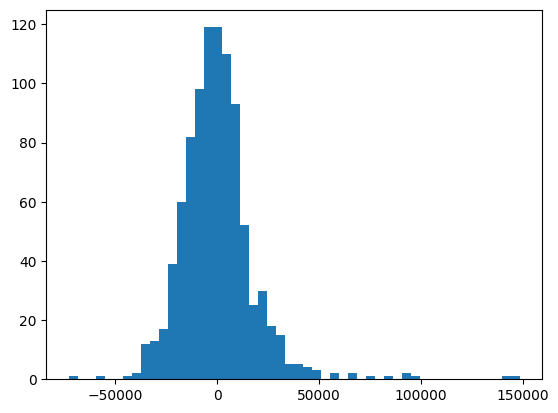

In [ ]:
# GLM
model_ols = sm.OLS(y_train, X_train_constant).fit()
residuals_train = model_ols.resid
plt.hist(residuals_train, bins=50)
plt.show()

In [ ]:
for i in transformation_values_table['Transformation']:
  if not ((summary_table['Transformation'] == i) & (summary_table['Model'] == 'GLM')).any():
    y_train_trans, y_test_trans = transform(y_train, i), transform(y_test, i)

    model_glm = sm.GLM(y_train_trans, X_train_constant, family = sm.families.Gamma(link = sm.families.links.Log())).fit()
    residuals_train_glm, residuals_test_glm = obtain_residuals(model_glm)
    summary_table = new_row(model_glm, residuals_train_glm, residuals_test_glm, 'GLM')

In [ ]:
#summary_table = summary_table.drop([20], axis=0)
#summary_table.loc[0, 'Transformation'] = 'x^1'
#summary_table = summary_table.sort_values(by='Transformation')
#summary_table.reset_index(drop=True, inplace=True)

display(summary_table.tail(40))

,Transformation,Model,Adj R2,Durbin Watson,Jarque Bera,Norm Train,Norm Test,Hetero Train
177,ln^-1/5(x),GLS,0.842714,1.956008,1.119962e-02,2.186015e-01,1.950220e-01,3.175057e-07
178,ln(ln(x)),GLS,0.842299,1.957500,6.337150e-03,2.022445e-01,1.839390e-01,3.338071e-07
179,ln^0.09(x),GLS,0.842091,1.958211,4.663896e-03,1.911598e-01,1.777752e-01,3.386245e-07
180,ln^1/5(x),GLS,0.841852,1.959005,3.217029e-03,1.777298e-01,1.706718e-01,3.416797e-07
181,ln^1/4(x),GLS,0.841735,1.959383,2.667212e-03,1.711734e-01,1.672886e-01,3.422629e-07
182,ln^1/3(x),GLS,0.841536,1.960014,1.919387e-03,1.595278e-01,1.616600e-01,3.419966e-07
183,ln^1/2(x),GLS,0.841123,1.961281,9.313267e-04,1.358577e-01,1.496038e-01,3.369141e-07
184,ln^3/2(x),GLS,0.838189,1.968957,1.341870e-06,3.744478e-02,8.601249e-02,2.163283e-07
185,ln^2(x),GLS,0.836435,1.972797,8.150914e-09,1.458796e-02,5.380994e-02,1.412476e-07
186,x^-2,GLM,0.995483,1.965032,0.000000e+00,0.000000e+00,0.000000e+00,4.981279e-21


In [ ]:
summary_table.to_csv('/content/drive/MyDrive/Personal Files/Regression Practice/Summary_Table_4.csv', index=False)

In [ ]:
summary_table_reduced = summary_table[summary_table['Norm Train'] >= 0.05]
summary_table_reduced = summary_table_reduced[summary_table_reduced['Norm Test'] >= 0.05]
summary_table_reduced = summary_table_reduced[summary_table_reduced['Norm Test'] >= 0.05]
summary_table_reduced = summary_table_reduced[summary_table_reduced['Jarque Bera'] >= 0.05]
display(summary_table_reduced)

,Transformation,Model,Adj R2,Durbin Watson,Jarque Bera,Norm Train,Norm Test,Hetero Train
5,x^-1/4,OLS,0.844861,1.952486,0.055533,0.120076,0.205820,1.187292e-07
6,x^-1/5,OLS,0.844292,1.955527,0.056620,0.200839,0.218480,2.070332e-07
17,ln^-3/2(x),OLS,0.844483,1.952693,0.050281,0.134095,0.206911,1.168984e-07
49,ln^-1(x),OLS Elastic,0.699239,1.958056,0.779061,0.868954,0.559622,6.210349e-12
50,ln^-1/2(x),OLS Elastic,0.747708,1.966095,0.232753,0.142128,0.177222,4.650706e-10
51,ln^-1/3(x),OLS Elastic,0.740936,1.964394,0.154519,0.095850,0.203091,1.264710e-09
52,ln^-1/4(x),OLS Elastic,0.722052,1.957215,0.237888,0.227705,0.121397,5.719623e-10
53,ln^-1/5(x),OLS Elastic,0.703815,1.949117,0.108203,0.196983,0.075768,7.490574e-11
78,ln^-2(x),WLS1,0.835736,1.945793,0.066115,0.158838,0.095988,1.694569e-07
79,ln^-3/2(x),WLS1,0.837663,1.949832,0.066605,0.238123,0.117386,1.950944e-07


In [ ]:
# ln^-1(x) GLM seems like the best model